In [1]:
#імпорти
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Визначення середовища
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab")
except:
    IN_COLAB = False
    print("Running locally")

# Завантаження датасету
if IN_COLAB:
    # В Colab - завантажуємо з GitHub
    dataset_path = 'https://raw.githubusercontent.com/Sarmatae685/Intelligent-Data-Analysis/main/lab3-regression/lab3_regression.csv'
else:
    # Локально - файл поруч
    dataset_path = 'lab3_regression.csv'

df = pd.read_csv(dataset_path)
print(f"✅ Dataset loaded: {len(df)} records, {len(df.columns)} features")
df.head()

Mounted at /content/drive


In [2]:
df = df.dropna().reset_index(drop=True) #видаляє всі рядки, де пропущене хоча б 1 значення
                                        #скидає індекси, щоб уникнути пробілів в нумерації
y = df['Metascore']
df = df.drop('Metascore', axis=1)


top_genres = df['Genre'].explode().value_counts().nlargest(3).index   # 3- для обмеження кількості категорій
top_actors = df['Actors'].explode().value_counts().nlargest(3).index  # і спрощення навчання моделі (скорочення кі-сті бінарних ознак)

for genre in top_genres:
    df[f'Genre_{genre}'] = df['Genre'].apply(lambda x: 1 if genre in x else 0)

for actor in top_actors:
    df[f'Actor_{actor}'] = df['Actors'].apply(lambda x: 1 if actor in x else 0)

df = df.drop(['Genre', 'Actors'], axis=1)

Якщо top_genres = ['Action', 'Comedy', 'Drama'] і стовпець Genre виглядає так:

Genre
Action, Drama
Comedy
Action
Drama
Comedy, Drama

Після виконання отримуємо наступні стовпці:
Genre              Genre_Action  Genre_Comedy  Genre_Drama
Action, Drama      1             0             1
Comedy             0             1             0
Action             1             0             0
Drama              0             0             1
Comedy, Drama      0             1             1

In [3]:
#категоризація ознак
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True) #створює бінарні (0 або 1) стовпці для кожного можливого значення в категоріальних стовпцях.

Наприклад, якщо Genre має значення Action, Drama, Comedy, воно буде перетворено на

Genre_Action  Genre_Drama  Genre_Comedy
1             0            0
0             1            0
0             0            1

один зі стовпців видаляється, щоб уникнути лінійної залежності між ознаками:

Genre_Action  Genre_Drama
1             0  # Це означає "Action"
0             1  # Це означає "Drama"
0             0  # Це означає "Comedy"

Після цього перетворення таблиця більше не містить текстових даних або object-типів

In [13]:
# Вибір 5 ознак з найвищою кореляцією з Metascore
correlations = df.corrwith(y).abs().sort_values(ascending=False) # обчислює коефіцієнт кореляції між кожним стовпцем таблиці df та вектором y (від -1 до 1)
top_features = correlations.nlargest(5).index                    # наскільки сильно лінійно пов'язані дві змінні
X = df[top_features]
print(X)

     Rating   Votes  Genre_Drama  Runtime (Minutes)  Rank
0       8.1  757074            0                121     1
1       7.0  485820            0                124     2
2       7.3  157606            0                117     3
3       7.2   60545            0                108     4
4       6.2  393727            0                123     5
..      ...     ...          ...                ...   ...
833     5.9  140900            0                 97   994
834     6.7  164088            0                 88   995
835     5.5   73152            0                 94   997
836     6.2   70699            1                 98   998
837     5.3   12435            0                 87  1000

[838 rows x 5 columns]


corrwith - обчислює коефіцієнт кореляції між кожним стовпцем таблиці df та вектором y (від -1 до 1)
тобто наскільки сильно лінійно пов'язані дві змінні

Метод abs() бере абсолютне значення кореляції. Це потрібно, щоб враховувати як позитивну, так і негативну кореляцію. якщо кореляція стовпця з Metascore дорівнює -0.8, то після abs() це буде 0.8

.sort_values(ascending=False) - Сортує ознаки за значенням кореляції у порядку спадання. Наприклад:
Revenue    0.85
Votes      0.78
Runtime    0.60
Rating     0.58
Year       0.40

correlations.nlargest(5) - Вибирає 5 найбільших значень кореляції з отриманого списку

Кореляція вказує на те, наскільки сильно зміни в ознаці (наприклад, Revenue) пов'язані зі змінами в цільовій змінній (Metascore). Наприклад:

- Якщо кореляція Revenue дорівнює 0.85:
Це означає, що збільшення доходів (Revenue) фільму зазвичай супроводжується збільшенням оцінки Metascore.
- Якщо кореляція Year дорівнює -0.40:
Це означає, що новіші фільми можуть мати нижчу оцінку Metascore (негативний зв’язок).

- Rating: Рейтинг фільму (за шкалою від 1 до 10).
- Votes: Кількість голосів, які фільм отримав (популярність фільму).
- Genre_Drama: Бінарна ознака (0 або 1), яка вказує, чи належить фільм до жанру "Drama".
- Runtime (Minutes): Тривалість фільму в хвилинах.
- Rank: Ранг фільму

In [5]:
print("Обрані ознаки для тренування:")
print(X.head()) # перегляд перших кількох рядків таблиці

Обрані ознаки для тренування:
   Rating   Votes  Genre_Drama  Runtime (Minutes)  Rank
0     8.1  757074            0                121     1
1     7.0  485820            0                124     2
2     7.3  157606            0                117     3
3     7.2   60545            0                108     4
4     6.2  393727            0                123     5


In [6]:
# Розділення на тренувальний і тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
print("Тренувальний набір:")
print(X_train.head(), "\n")
print(y_train.head())
print("\nТестовий набір:")
print(X_test.head(), "\n")
print(y_test.head())

# вхідні дані - стандартизація
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Тренувальний набір:
     Rating   Votes  Genre_Drama  Runtime (Minutes)  Rank
818     5.9   64513            1                123   973
234     6.2   21715            1                108   263
220     7.1  188017            0                119   249
576     6.5  168875            1                129   669
334     6.9   31776            1                111   375 

818    47.0
234    79.0
220    75.0
576    45.0
334    71.0
Name: Metascore, dtype: float64

Тестовий набір:
     Rating   Votes  Genre_Drama  Runtime (Minutes)  Rank
210     8.1  530881            1                 99   239
824     5.3   27312            1                118   982
78      7.4  162122            1                128    90
67      7.3  552027            0                151    79
679     6.2  178243            0                108   796 

210    88.0
824    33.0
78     51.0
67     53.0
679    50.0
Name: Metascore, dtype: float64


In [8]:
# POLYNOMIAL REGRESSION Виконання
print("\nPolynomial Regression:")
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

y_pred_poly = poly_model.predict(X_test_poly)

# Обчислення метрик для Polynomial Regression
poly_explained_variance = explained_variance_score(y_test, y_pred_poly)
poly_mae = mean_absolute_error(y_test, y_pred_poly)
poly_mse = mean_squared_error(y_test, y_pred_poly)
poly_mape = mean_absolute_percentage_error(y_test, y_pred_poly)
poly_r2 = r2_score(y_test, y_pred_poly)

print(f"Explained Variance: {poly_explained_variance}")
print(f"Mean Absolute Error (MAE): {poly_mae}")
print(f"Mean Squared Error (MSE): {poly_mse}")
print(f"Mean Absolute Percentage Error (MAPE): {poly_mape}")
print(f"R-squared (R²): {poly_r2}")


Polynomial Regression:
Explained Variance: 0.47542274586275046
Mean Absolute Error (MAE): 9.569820646255735
Mean Squared Error (MSE): 146.52391540990413
Mean Absolute Percentage Error (MAPE): 0.18569438365702612
R-squared (R²): 0.4754138488852271


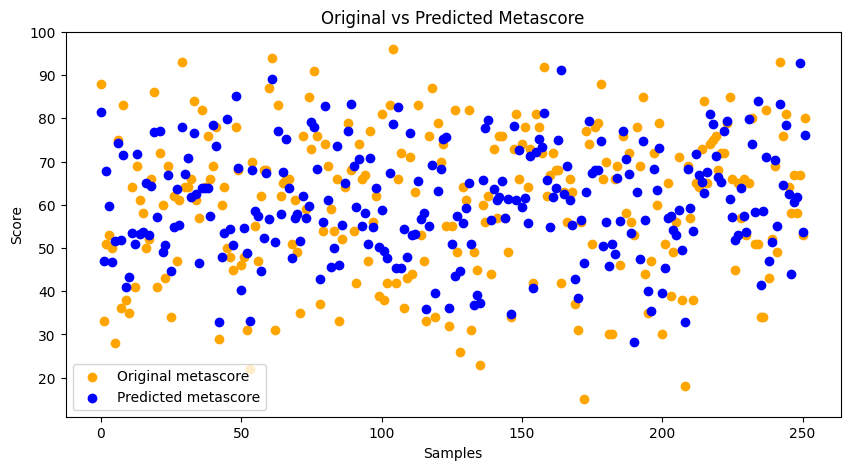

In [9]:
# Візуалізація результатів Polynomial Regression
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='orange', label="Original metascore")  # Фактичні значення
plt.scatter(range(len(y_pred_poly)), y_pred_poly, color='blue', label="Predicted metascore")  # Передбачені значення
plt.xlabel("Samples")
plt.ylabel("Score")
plt.title("Original vs Predicted Metascore")
plt.legend()
plt.show()

In [10]:
# Звільняємо пам'ять
del X_train_poly, X_test_poly, poly_model, y_pred_poly

In [11]:
# Ridge regression виконання
print("\nRidge Regression:")
ridge_model = Ridge(alpha=1.0)  # Параметр регуляризації
ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

ridge_explained_variance = explained_variance_score(y_test, y_pred_ridge)
ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_mse = mean_squared_error(y_test, y_pred_ridge)
ridge_mape = mean_absolute_percentage_error(y_test, y_pred_ridge)
ridge_r2 = r2_score(y_test, y_pred_ridge)

print(f"Explained Variance: {ridge_explained_variance}") #наскільки добре модель пояснює варіацію даних
print(f"Mean Absolute Error (MAE): {ridge_mae}") #середні помилки
print(f"Mean Squared Error (MSE): {ridge_mse}")
print(f"Mean Absolute Percentage Error (MAPE): {ridge_mape}")
print(f"R-squared (R²): {ridge_r2}") # міра точності моделі


Ridge Regression:
Explained Variance: 0.5038679406021604
Mean Absolute Error (MAE): 9.462024221697805
Mean Squared Error (MSE): 138.96164569904062
Mean Absolute Percentage Error (MAPE): 0.18122421953243964
R-squared (R²): 0.5024883503426565


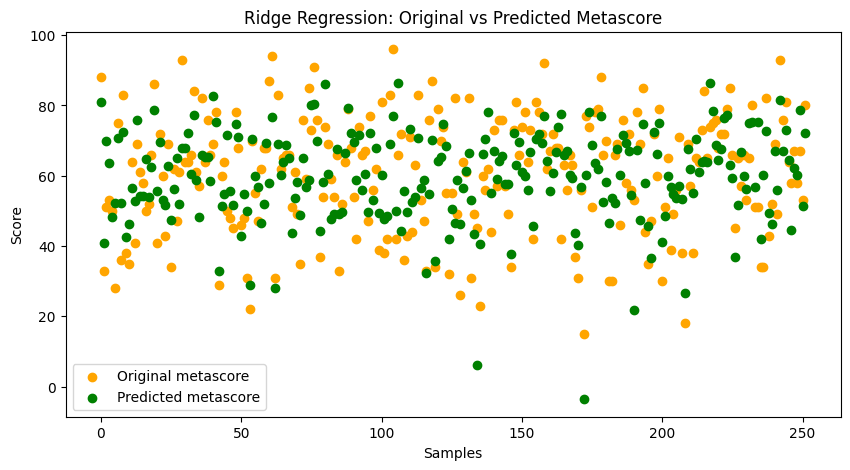

In [12]:
# Візуалізація результатів Ridge Regression
plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_test)), y_test, color='orange', label="Original metascore")  # Фактичні значення
plt.scatter(range(len(y_pred_ridge)), y_pred_ridge, color='green', label="Predicted metascore")  # Передбачені значення
plt.xlabel("Samples")
plt.ylabel("Score")
plt.title("Ridge Regression: Original vs Predicted Metascore")
plt.legend()
plt.show()